In [1]:
import os
print(os.getcwd()) # check the current working directory

# os.chdir('C:\\Users\\u5819317\\MikeMike\\Zhuoran Liu_S1 2019\\PythonProjection\\Leisure_1') # change the current working directory
# print(os.getcwd())

In [2]:
## Initial setting

import pandas as pd
interestTable = pd.read_csv('return_H.csv', usecols=[1,2,3])  ## Import interest rate
mortalityTable = pd.read_csv('newmort2.csv', usecols=[1,2,3])  ## Import mortality table

import numpy as np
from datascience import Table
Expectation = Table.from_df(interestTable)  ## Convert readin csv file to 'table'

α = 0.9
ρ = 5
β = 1

grids = 40
Upper_grid = 2000000.0
Lower_grid = Upper_grid / grids
A109 = np.arange(Lower_grid, Upper_grid+1, int(Upper_grid/grids))
print(A109)

Y1 = 85000 # prior retirement income
Y2 = 30000 # post retirement income

# θ = 0.5 ## Constant assets allocation rate

import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import root

[  50000.  100000.  150000.  200000.  250000.  300000.  350000.  400000.
  450000.  500000.  550000.  600000.  650000.  700000.  750000.  800000.
  850000.  900000.  950000. 1000000. 1050000. 1100000. 1150000. 1200000.
 1250000. 1300000. 1350000. 1400000. 1450000. 1500000. 1550000. 1600000.
 1650000. 1700000. 1750000. 1800000. 1850000. 1900000. 1950000. 2000000.]


### 1. Solve for age 109

In [3]:
# from scipy.optimize import root # only useful when trying to find optimal assets allocation rate through root finding

def func(θ):
    Expect0 = 1 + θ*Expectation.column('Eq') + (1-θ)*Expectation.column('Bond')
    Expect1 = (Expect0*node + Y2) / node ## scaling here
    Expect2 = np.power(Expect1, α*(1-ρ)-1)
    Expect3 = Expectation.column('Eq') - Expectation.column('Bond')
    Expect4 = Expectation.column('Probability') * (Expect2*Expect3)
    return Expect4.sum()

θ109 = []
C109 = []
L109 = []
for index, node in enumerate(A109):
    sol = root(func, 0.1)  ## 0.1 is the starting point of θ
    θxx = sol.x
    if θxx <= 0: ## Constraint
        θxx = 0
    elif θxx >= 1:
        θxx = 1
    θ109.append(θxx)

    leisure1 = 1 + (1-θ109[index])*Expectation.column('Bond') + θ109[index]*Expectation.column('Eq') # (1+i)
    leisure2 = np.power(leisure1, α*(1-ρ)) * Expectation.column('Probability') # Expectation
    leisure3 = β * (1-mortalityTable['X'][108]) * leisure2.sum() # A number
    leisure4 = np.power((1-α)*node/(α*Y2), α*(1-ρ)-1) * leisure3 
    leisure5 = np.power(leisure4, -1/ρ) ## Unconstraint leisure
    if leisure5 <= 2/7:
        leisure5 = 2/7
    elif leisure5 >= 1:
        leisure5 = 1
    
    consum1 = leisure3 / (np.power(leisure5, (1-α)*(1-ρ)))
    consum2 = np.power(consum1, 1/(α*(1-ρ)-1))
    consum3 = node * consum2
    C109.append(consum3)
    L109.append(leisure5)


θ109 = np.squeeze(θ109)
M109 = A109 - Y2*(1-np.array(L109)) + C109

print('Optimal risky assets allocation rate at 109 is ' + str(θ109))
print('Optimal consumption at 109 is ' + str(C109))
print('Constrained optimal leisure time at 109 is ' + str(L109))

Optimal risky assets allocation rate at 109 is [0.57029641 0.48601287 0.45796797 0.44395718 0.43555479 0.429955
 0.42595606 0.42295736 0.42062534 0.41875992 0.41723381 0.41596213
 0.41488616 0.41396395 0.41316474 0.41246545 0.41184846 0.41130003
 0.41080935 0.41036775 0.40996821 0.40960501 0.40927339 0.40896941
 0.40868975 0.40843162 0.4081926  0.40797066 0.40776403 0.40757118
 0.40739077 0.40722163 0.40706275 0.40691322 0.40677223 0.40663908
 0.40651312 0.4063938  0.40628059 0.40617305]
Optimal consumption at 109 is [64535.03866326148, 124002.96060911693, 180103.6926988582, 234690.8255873661, 289819.8929150168, 347790.32445016276, 405759.90330489766, 463728.9522241984, 521697.6493159113, 579666.1009126919, 637634.3744190366, 695602.5146321836, 753570.5524869878, 811538.5100330358, 869506.4034110425, 927474.2447079187, 985442.0431542536, 1043409.8059209934, 1101377.5386635584, 1159345.2459021225, 1217312.9312928566, 1275280.5978249526, 1333248.247966081, 1391215.8837713753, 1449183.506

## Age 108-65

In [4]:
Optimal_results_EGM = Table().with_columns([
    'A109', A109,
    'C109', C109,
    'L109', L109,
    'M109', M109,
])
Optimal_θx = Table().with_columns([
    'θ109', θ109,
])

from scipy.interpolate import interp1d
def solve_108_65(A, age, income, table, raa):
    '''
    solve for optimal consumption and leisure for age 108-65
    only constraints on leisure, no constraints on consumption
    '''
    interest = 1 + raa*Expectation.column('Eq') + (1-raa)*Expectation.column('Bond') ##two global vectors
    Interpolation_C = interp1d(table.column(4*(108-age)+3), table.column(4*(108-age)+1), \
                               kind='linear', fill_value='extrapolate')
    Interpolation_L = interp1d(table.column(4*(108-age)+3), table.column(4*(108-age)+2), \
                               kind='linear', fill_value='extrapolate')
    C_next = Interpolation_C(A * interest) # this is a vector
    L_next = Interpolation_L(A * interest)
    
    numerator_L = β*(1-mortalityTable['X'][age-1]) * (α * np.power(C_next,α*(1-ρ)-1) * np.power(L_next,(1-α)*(1-ρ))\
                                                    *interest*Expectation.column('Probability')).sum()
    denominator_L = α * np.power((α*income)/(1-α), α*(1-ρ)-1)
    L_new = np.power(numerator_L / denominator_L, -1/ρ)
    if L_new <= 2/7:
        L_new = 2/7
    elif L_new > 1:
        L_new = 1
    
    denominator_C = α * np.power(L_new, (1-α)*(1-ρ))
    C_new = np.power(numerator_L / denominator_C, 1/(α*(1-ρ)-1))
    return C_new, L_new


In [5]:
Optimal_results_EGM.show(2)

A109,C109,L109,M109
50000,64535,0.285714,93106.5
100000,124003,0.45927,207781


In [6]:
import time
start_time = time.time()

for i in range(44): # age 108-65 -> i 0-43
    Ax = A109
    Optimal_results_EGM = Optimal_results_EGM.with_column('A%1d'%(108-i), Ax)
    
    θx = []
    def theta_108_65(x):
        Interpo1 = 1 + (1-x)*Expectation.column('Bond') + x*Expectation.column('Eq')
        Interpo2 = node * Interpo1  ## node is the value for each Mx
        Interpolation_C = interp1d(Optimal_results_EGM.column(4*i+3), Optimal_results_EGM.column(4*i+1), \
                                   kind='linear', fill_value='extrapolate')
        Interpolation_L = interp1d(Optimal_results_EGM.column(4*i+3), Optimal_results_EGM.column(4*i+2), \
                                   kind='linear', fill_value='extrapolate')
        Interpo3_C = Interpolation_C(Interpo2) / Optimal_results_EGM.column(4*i+1)[Ax==node] 
                   ## Divided by a constant here and get a value close to 1, for later take power of -ρ.
        Interpo3_L = Interpolation_L(Interpo2)
        Interpo4 = np.power(Interpo3_C, α*(1-ρ)-1) * np.power(Interpo3_L, (1-α)*(1-ρ)) * (Expectation.column('Eq') - Expectation.column('Bond'))
        Interpo5 = (Expectation.column('Probability') * Interpo4).sum()
        return(Interpo5) 
    
    Cx = [] 
    Lx = []
    
    for node in Ax:
        init = 0.1
        solution = root(theta_108_65, init)
        while not solution.success:
            init += 0.01
            solution = root(theta_108_65, init)
        θxx = float(solution.x)
        if θxx <= 0: ## Constraint
            θxx = 0
        elif θxx >= 1:
            θxx = 1
        θx.append(θxx)
        
        Cxx, Lxx = solve_108_65(A=node, age=108-i, income=Y2, table=Optimal_results_EGM, raa=θxx)
        Cx.append(Cxx)
        Lx.append(Lxx)
    
    θx = np.squeeze(θx)
    Optimal_θx = Optimal_θx.with_column('θ%1d'%(108-i), θx)
    Optimal_results_EGM = Optimal_results_EGM.with_column('C%1d'%(108-i), Cx)
    Optimal_results_EGM = Optimal_results_EGM.with_column('L%1d'%(108-i), Lx)
    Mx = Ax - Y2*(1-np.array(Lx)) + Cx
    Optimal_results_EGM = Optimal_results_EGM.with_column('M%1d'%(108-i), Mx)

print("--- %s seconds ---" % (time.time() - start_time))

Optimal_results_EGM.show(3)

--- 3.5488381385803223 seconds ---


A109,C109,L109,M109,A108,C108,L108,M108,A107,C107,L107,M107,A106,C106,L106,M106,A105,C105,L105,M105,A104,C104,L104,M104,A103,C103,L103,M103,A102,C102,L102,M102,A101,C101,L101,M101,A100,C100,L100,M100,A99,C99,L99,M99,A98,C98,L98,M98,A97,C97,L97,M97,A96,C96,L96,M96,A95,C95,L95,M95,A94,C94,L94,M94,A93,C93,L93,M93,A92,C92,L92,M92,A91,C91,L91,M91,A90,C90,L90,M90,A89,C89,L89,M89,A88,C88,L88,M88,A87,C87,L87,M87,A86,C86,L86,M86,A85,C85,L85,M85,A84,C84,L84,M84,A83,C83,L83,M83,A82,C82,L82,M82,A81,C81,L81,M81,A80,C80,L80,M80,A79,C79,L79,M79,A78,C78,L78,M78,A77,C77,L77,M77,A76,C76,L76,M76,A75,C75,L75,M75,A74,C74,L74,M74,A73,C73,L73,M73,A72,C72,L72,M72,A71,C71,L71,M71,A70,C70,L70,M70,A69,C69,L69,M69,A68,C68,L68,M68,A67,C67,L67,M67,A66,C66,L66,M66,A65,C65,L65,M65
50000,64535,0.285714,93106.5,50000,47104.3,0.285714,75675.7,50000,42169.3,0.285714,70740.7,50000,40265.8,0.285714,68837.2,50000,39521.1,0.285714,68092.5,50000,39307.8,0.285714,67879.2,50000,39332.9,0.285714,67904.3,50000,39473.8,0.285714,68045.3,50000,39654.7,0.285714,68226.1,50000,39825.8,0.285714,68397.3,50000,39953.8,0.285714,68525.2,50000,40054.8,0.285714,68626.2,50000,40089.7,0.285714,68661.2,50000,40033.5,0.285714,68605,50000,39872.6,0.285714,68444,50000,39603.4,0.285714,68174.8,50000,39229.3,0.285714,67800.8,50000,38759.4,0.285714,67330.9,50000,38207.3,0.285714,66778.7,50000,37590.1,0.285714,66161.6,50000,36926.8,0.285714,65498.3,50000,36234,0.285714,64805.4,50000,35525.2,0.285714,64096.6,50000,34811.6,0.285714,63383,50000,34102,0.285714,62673.4,50000,33403.6,0.285714,61975,50000,32721.8,0.285714,61293.2,50000,32060.7,0.285714,60632.1,50000,31423.3,0.285714,59994.7,50000,30811.6,0.285714,59383,50000,30226.9,0.285714,58798.3,50000,29669.7,0.285714,58241.2,50000,29140,0.285714,57711.5,50000,28637.4,0.285714,57208.8,50000,28161.1,0.285714,56732.5,50000,27710.4,0.285714,56281.8,50000,27284.5,0.285714,55855.9,50000,26882.5,0.285714,55453.9,50000,26503.4,0.285714,55074.9,50000,26146.2,0.285714,54717.7,50000,25809.8,0.285714,54381.2,50000,25493,0.285714,54064.4,50000,25194.5,0.285714,53765.9,50000,24913.1,0.285714,53484.5,50000,24647.5,0.285714,53218.9
100000,124003,0.45927,207781,100000,78343.1,0.29016,157048,100000,64312.4,0.285714,142884,100000,57867.5,0.285714,136439,100000,54396.3,0.285714,132968,100000,52356.3,0.285714,130928,100000,51083.7,0.285714,129655,100000,50261.6,0.285714,128833,100000,49700.5,0.285714,128272,100000,49281,0.285714,127852,100000,48925,0.285714,127496,100000,48626.8,0.285714,127198,100000,48320.5,0.285714,126892,100000,47960.8,0.285714,126532,100000,47517.5,0.285714,126089,100000,46980.9,0.285714,125552,100000,46350.4,0.285714,124922,100000,45633.3,0.285714,124205,100000,44842.4,0.285714,123414,100000,43995.3,0.285714,122567,100000,43111.6,0.285714,121683,100000,42208.7,0.285714,120780,100000,41300.4,0.285714,119872,100000,40397.7,0.285714,118969,100000,39509.4,0.285714,118081,100000,38642.5,0.285714,117214,100000,37802.3,0.285714,116374,100000,36992.4,0.285714,115564,100000,36215.6,0.285714,114787,100000,35473.1,0.285714,114045,100000,34765.8,0.285714,113337,100000,34093.8,0.285714,112665,100000,33456.3,0.285714,112028,100000,32852.6,0.285714,111424,100000,32281.4,0.285714,110853,100000,31741.7,0.285714,110313,100000,31232.2,0.285714,109804,100000,30751.6,0.285714,109323,100000,30298.7,0.285714,108870,100000,29872.1,0.285714,108444,100000,29470.4,0.285714,108042,100000,29091.9,0.285714,107663,100000,28735.2,0.285714,107307,100000,28398.7,0.285714,106970,100000,28080.8,0.285714,106652
150000,180104,0.667051,320115,150000,107580,0.398445,239534,150000,85700.9,0.317411,215223,150000,75430.7,0.285714,204002,150000,69254.1,0.285714,197826,150000,65391.5,0.285714,193963,150000,62801.9,0.285714,191373,150000,60988.5,0.285714,189560,150000,59654.8,0.285714,188226,150000,58614.8,0.285714,187186,150000,57746.7,0.285714,186318,150000,57023.4,0.285714,185595,150000,56352.5,0.285714,184924,150000,55672.6,0.285714,184244,150000,54944.1,0.285714,183516,150000,54143.3

In [7]:
Optimal_θx.show(3)

θ109,θ108,θ107,θ106,θ105,θ104,θ103,θ102,θ101,θ100,θ99,θ98,θ97,θ96,θ95,θ94,θ93,θ92,θ91,θ90,θ89,θ88,θ87,θ86,θ85,θ84,θ83,θ82,θ81,θ80,θ79,θ78,θ77,θ76,θ75,θ74,θ73,θ72,θ71,θ70,θ69,θ68,θ67,θ66,θ65
0.570296,0.556771,0.665268,0.776788,0.884923,0.989177,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.486013,0.469443,0.532818,0.588999,0.642936,0.694948,0.74507,0.792295,0.836315,0.877037,0.914462,0.948643,0.979699,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.457968,0.43998,0.488335,0.528111,0.562974,0.597397,0.630753,0.662809,0.693208,0.721732,0.748272,0.772794,0.795313,0.815884,0.834496,0.851116,0.866202,0.880015,0.892736,0.904502,0.915425,0.925676,0.9353,0.944327,0.952788,0.96074,0.968237,0.975446,0.982348,0.988972,0.995322,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## At age 64

In [8]:
def solve_64(A, age, income, table, raa):
    '''
    solve for optimal consumption and leisure for age 64
    constraints on both leisure and consumption
    '''
    interest = 1 + raa*Expectation.column('Eq') + (1-raa)*Expectation.column('Bond') ##two global vectors
    Interpolation_C = interp1d(table.column(4*(108-age)+3), table.column(4*(108-age)+1), \
                               kind='linear', fill_value='extrapolate')
    Interpolation_L = interp1d(table.column(4*(108-age)+3), table.column(4*(108-age)+2), \
                               kind='linear', fill_value='extrapolate')
    C_next = Interpolation_C(A * interest) # this is a vector
    L_next = Interpolation_L(A * interest)
    numerator_L = β*(1-mortalityTable['X'][age-1]) * (α * np.power(C_next,α*(1-ρ)-1) * np.power(L_next,(1-α)*(1-ρ)) \
                                                     * interest*Expectation.column('Probability')).sum()
    denominator_L = α * np.power((α*income)/(1-α), α*(1-ρ)-1)
    L_new = np.power(numerator_L / denominator_L, -1/ρ)
    L_uncon = L_new  
    if L_new <= 2/7:
        L_new = 2/7
    elif L_new > 1:
        L_new = 1

    denominator_C = α * np.power(L_new, (1-α)*(1-ρ))
    C_new = np.power(numerator_L / denominator_C, 1/(α*(1-ρ)-1))
    C_uncon = C_new
    
    if C_new > income: ## check constraints on consumption
        C_new = income
        L_new = np.power(numerator_L * income / ((1-α)*np.power(C_new,α*(1-ρ)))\
                         , 1/((1-α)*(1-ρ)-1)) # recalculate optimal leisure
        L_uncon = L_new
        if L_new <= 2/7: # re-check constraints on leisure
            L_new = 2/7          
        elif L_new > 1:
            L_new = 1

    return C_new, L_new, C_uncon, L_uncon

def theta64(x):
    Interpo1 = 1 + (1-x)*Expectation.column('Bond') + x*Expectation.column('Eq')
    Interpo2 = node * Interpo1  ## node is the value for each Mx
    Interpolation_C = interp1d(Optimal_results_EGM.column(4*43+3), Optimal_results_EGM.column(4*43+1), \
                               kind='linear', fill_value='extrapolate')
    Interpolation_L = interp1d(Optimal_results_EGM.column(4*43+3), Optimal_results_EGM.column(4*43+2), \
                               kind='linear', fill_value='extrapolate')
    Interpo3_C = Interpolation_C(Interpo2) / Optimal_results_EGM.column(4*i+1)[Ax==node] 
               ## Divided by a constant here and get a value close to 1, for later take power of -ρ.
    Interpo3_L = Interpolation_L(Interpo2)
    Interpo4 = np.power(Interpo3_C, α*(1-ρ)-1) * np.power(Interpo3_L, (1-α)*(1-ρ)) * (Expectation.column('Eq') - Expectation.column('Bond'))
    Interpo5 = (Expectation.column('Probability') * Interpo4).sum()
    return(Interpo5)

A64 = A109
C64 = [] 
L64 = []
C_un64 = []
L_un64 = []
θ64 = []

for node in A64:
    init = 0.1
    solution = root(theta64, init)
    while not solution.success:
        init += 0.01
        solution = root(theta64, init)
    θ = float(solution.x)
    if θ <= 0: ## Constraint
        θ = 0
    elif θ >= 1:
        θ = 1
    θ64.append(θ)    
    
    Cxx, Lxx, C_uncon, L_uncon = solve_64(A=node, age=64, income=Y1, table=Optimal_results_EGM, raa=θ)
    L64.append(Lxx) 
    C64.append(Cxx)
    C_un64.append(C_uncon)
    L_un64.append(L_uncon)
    
M64 = A64 - Y1*(1-np.array(L64)) + C64
Optimal_results_EGM_64 = Table().with_columns([
    'A64', A64,
    'C64', C64,
    'L64', L64,
    'M64', M64,
    'C_un64', C_un64,
    'L_un64', L_un64,
])

Optimal_results_EGM_64.show(3)

A64,C64,L64,M64,C_un64,L_un64
50000,24396.5,0.285714,13682.2,24396.5,0.0380055
100000,27780.2,0.285714,67065.9,27780.2,0.0428295
150000,30987.3,0.285714,120273,30987.3,0.0473582


## Age 63-25

In [9]:
def solve_63_25(A, age, income, table, raa):
    '''
    solve for optimal consumption and leisure for age 63-25
    constraints on both leisure and consumption
    '''
    interest = 1 + raa*Expectation.column('Eq') + (1-raa)*Expectation.column('Bond') ##two global vectors
    
    Interpolation_C2 = interp1d(table.column(6*(63-age)+3), table.column(6*(63-age)+4), \
                               kind='linear', fill_value='extrapolate')
    Interpolation_L = interp1d(table.column(6*(63-age)+3), table.column(6*(63-age)+2), \
                               kind='linear', fill_value='extrapolate')
    C_next2 = Interpolation_C2(A * interest) # unconstrained consumption
    L_next = Interpolation_L(A * interest) # constrained leisure
    
    Interpolation_L2 = interp1d(table.column(6*(63-age)+3), table.column(6*(63-age)+5), \
                               kind='linear', fill_value='extrapolate')
    Interpolation_C = interp1d(table.column(6*(63-age)+3), table.column(6*(63-age)+1), \
                               kind='linear', fill_value='extrapolate')
    C_next = Interpolation_C(A * interest) # constrained consumption
    L_next2 = Interpolation_L2(A * interest) # unconstrained leisure

    denominator_L = α * np.power((α*income)/(1-α), α*(1-ρ)-1)
    
    numerator_L1 = β*(1-mortalityTable['X'][age-1]) * ((α * np.power(C_next2[C_next2<income],α*(1-ρ)-1) \
                  * np.power(L_next[C_next2<income],(1-α)*(1-ρ)) ) * interest[C_next2<income] \
                  * Expectation.column('Probability')[C_next2<income] ).sum()    
    numerator_L2 = β*(1-mortalityTable['X'][age-1]) * (((1-α) * np.power(income,α*(1-ρ)) \
                  * np.power(L_next2[C_next2>income],(1-α)*(1-ρ)-1) ) * interest[C_next2>income] \
                  * Expectation.column('Probability')[C_next2>income] ).sum() / income    
    RHS = numerator_L1+numerator_L2
    L_new = np.power(RHS / denominator_L, -1/ρ)
    L_uncon = L_new

    if L_new <= 2/7:
        L_new = 2/7
    elif L_new > 1:
        L_new = 1
    denominator_C = α * np.power(L_new, (1-α)*(1-ρ))
    C_new = np.power(RHS / denominator_C, 1/(α*(1-ρ)-1))
    C_uncon = C_new

    if C_new > income: ## check constraints on consumption
        C_new = income
        L_new = np.power(RHS * income / ((1-α)*np.power(C_new,α*(1-ρ))), 1/((1-α)*(1-ρ)-1))
        L_uncon = L_new

        if L_new < 2/7:
            L_new = 2/7           
        elif L_new > 1:
            L_new = 1          

    return C_new, L_new, C_uncon, L_uncon

In [10]:
import time
start_time = time.time()
Optimal_results_EGM_25_63 = Table().with_columns([
    'A64', A64,
    'C64', C64,
    'L64', L64,
    'M64', M64,
    'C_un64', C_un64,
    'L_un64', L_un64,
])
Optimal_θx_25_63 = Table().with_columns([
    'θ64', θ64,
])

for i in range(39): ## age 63-25 --> i from 0 to 38 (include)
    Ax = A109
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('A%1d'%(63-i), Ax)
    Cx = [] 
    Lx = []
    C_unx = []
    L_unx = []
    θx = []
    
    def theta_63_25(x):
        Interpo1 = 1 + (1-x)*Expectation.column('Bond') + x*Expectation.column('Eq')
        Interpo2 = node * Interpo1
        Interpolation_C = interp1d(Optimal_results_EGM_25_63.column(6*i+3), Optimal_results_EGM_25_63.column(6*i+1), \
                                   kind='linear', fill_value='extrapolate')       
        Interpolation_C2 = interp1d(Optimal_results_EGM_25_63.column(6*i+3), Optimal_results_EGM_25_63.column(6*i+4), \
                                   kind='linear', fill_value='extrapolate')
        Interpolation_L = interp1d(Optimal_results_EGM_25_63.column(6*i+3), Optimal_results_EGM_25_63.column(6*i+2), \
                                   kind='linear', fill_value='extrapolate')
        Interpolation_L2 = interp1d(Optimal_results_EGM_25_63.column(6*i+3), Optimal_results_EGM_25_63.column(6*i+5), \
                                   kind='linear', fill_value='extrapolate')
        C_next = Interpolation_C(Interpo2) # constrained consumption
        C_next2 = Interpolation_C2(Interpo2) # unconstrained consumption
        L_next = Interpolation_L(Interpo2) # constrained leisure
        L_next2 = Interpolation_L2(Interpo2) # unconstrained leisure
        Interpo4_1 = α * np.power(C_next2[C_next2<Y1], α*(1-ρ)-1) * np.power(L_next[C_next2<Y1], (1-α)*(1-ρ)) \
        * (Expectation.column('Eq')[C_next2<Y1] - Expectation.column('Bond')[C_next2<Y1]) * Expectation.column('Probability')[C_next2<Y1]
        Interpo4_2 = (1-α) * np.power(C_next[C_next2>Y1], α*(1-ρ)) * np.power(L_next2[C_next2>Y1], (1-α)*(1-ρ)-1) / Y1 \
        * (Expectation.column('Eq')[C_next2>Y1] - Expectation.column('Bond')[C_next2>Y1]) * Expectation.column('Probability')[C_next2>Y1]
        Interpo5 = Interpo4_1.sum() + Interpo4_2.sum()
        return(Interpo5)
    
    for node in Ax:
        init = 0.2
        solution = root(theta_63_25, init)
        while not solution.success:
            init += 0.01
            solution = root(theta_63_25, init)
        θ = float(solution.x)
        if θ <= 0: ## Constraint
            θ = 0
        elif θ >= 1:
            θ = 1
        θx.append(θ)
        
        Cxx, Lxx, C_unxx, L_unxx = solve_63_25(A=node, age=63-i, income=Y1, table=Optimal_results_EGM_25_63, raa=θ)
        Lx.append(Lxx) 
        Cx.append(Cxx)
        C_unx.append(C_unxx)
        L_unx.append(L_unxx)

    Optimal_θx_25_63 = Optimal_θx_25_63.with_column('θ%(age)1d'%{'age':63-i},θx)
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('C%1d'%(63-i), Cx)
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('L%1d'%(63-i), Lx)
    Mx = Ax - Y1*(1-np.array(Lx)) + Cx
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('M%1d'%(63-i), Mx)
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('C_un%1d'%(63-i), C_unx)
    Optimal_results_EGM_25_63 = Optimal_results_EGM_25_63.with_column('L_un%1d'%(63-i), L_unx)

print("--- %s seconds ---" % (time.time() - start_time))

# Optimal_results_EGM_25_63.show(3)

--- 6.091268062591553 seconds ---


In [11]:
Optimal_θx_25_63.show(3)

θ64,θ63,θ62,θ61,θ60,θ59,θ58,θ57,θ56,θ55,θ54,θ53,θ52,θ51,θ50,θ49,θ48,θ47,θ46,θ45,θ44,θ43,θ42,θ41,θ40,θ39,θ38,θ37,θ36,θ35,θ34,θ33,θ32,θ31,θ30,θ29,θ28,θ27,θ26,θ25
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# =========================VFI=========================

In [12]:
## Initial setting
M110 = np.arange(Lower_grid, Upper_grid+1, int(Upper_grid/grids))
interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')

Start_bal = Table()
for i in range(45):
    Start_bal = Start_bal.with_column('M%1d'%(109-i), Optimal_results_EGM.column(4*i+3))
Start_bal.show(3)

M109,M108,M107,M106,M105,M104,M103,M102,M101,M100,M99,M98,M97,M96,M95,M94,M93,M92,M91,M90,M89,M88,M87,M86,M85,M84,M83,M82,M81,M80,M79,M78,M77,M76,M75,M74,M73,M72,M71,M70,M69,M68,M67,M66,M65
93106.5,75675.7,70740.7,68837.2,68092.5,67879.2,67904.3,68045.3,68226.1,68397.3,68525.2,68626.2,68661.2,68605,68444,68174.8,67800.8,67330.9,66778.7,66161.6,65498.3,64805.4,64096.6,63383,62673.4,61975,61293.2,60632.1,59994.7,59383,58798.3,58241.2,57711.5,57208.8,56732.5,56281.8,55855.9,55453.9,55074.9,54717.7,54381.2,54064.4,53765.9,53484.5,53218.9
207781,157048,142884,136439,132968,130928,129655,128833,128272,127852,127496,127198,126892,126532,126089,125552,124922,124205,123414,122567,121683,120780,119872,118969,118081,117214,116374,115564,114787,114045,113337,112665,112028,111424,110853,110313,109804,109323,108870,108444,108042,107663,107307,106970,106652
320115,239534,215223,204002,197826,193963,191373,189560,188226,187186,186318,185595,184924,184244,183516,182715,181834,180876,179853,178783,177684,176576,175473,174385,173321,172289,171293,170337,169421,168549,167720,166933,166187,165481,164814,164183,163588,163027,162499,162001,161532,161090,160674,160281,159910


In [13]:
C110 = M110
L110 = [1] * (grids)
V110 = np.power(np.power(C110,α) * np.power(L110,1-α), 1-ρ) / (1-ρ)
V110_adj = np.power(np.power(V110*(1-ρ),1/(1-ρ)), 1/α)

Optimal_results_VFI = Table().with_columns([
    'M110', M110,
    'C110', C110,
    'L110', L110,
    'V110', V110,
    'V110_adj', V110_adj,
])

Optimal_results_VFI.show(3)

M110,C110,L110,V110,V110_adj
50000,50000,1,-3.03143e-18,50000
100000,100000,1,-2.5e-19,100000
150000,150000,1,-5.8078e-20,150000


## Age 109-65

In [14]:
from scipy.interpolate import interp1d
from scipy import optimize

def value_funtion(control_variables):
    C, L, θ = control_variables
    interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')
    value1 = np.power(np.power(C,α) * np.power(L,1-α), 1-ρ) / (1-ρ) # this is negative
    M_next = (node + (1-L)*Y2 - C) * (1+interest) # now it becomes a vector
    value2 = β * (1-mortalityTable['X'][108-i]) * interpo(M_nt=M_next, table=Optimal_results_VFI) 
        ## use another function, two control variables and one state variable
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    return -(value1+Ex_value2) * 1e18 ## To minimise, use negative results

def utility(C,L):
    u = np.power(np.power(C,α)*np.power(L,1-α), 1-ρ) / (1-ρ)
    return u

def transform(x):
    T = np.power(np.power(x*(1-ρ), 1/(1-ρ)), 1/α)
    return T

def solve():
    return optimize.minimize(value_funtion, initial_guess, method='SLSQP', tol=None, \
                             bounds = [(0,node+Y2), (2/7,1), (0,1)], options={'maxiter':200, 'ftol':1e-30})  
                            # method='L-BFGS-B'; method='SLSQP'

In [15]:
Optimal_results_EGM.show(1)

A109,C109,L109,M109,A108,C108,L108,M108,A107,C107,L107,M107,A106,C106,L106,M106,A105,C105,L105,M105,A104,C104,L104,M104,A103,C103,L103,M103,A102,C102,L102,M102,A101,C101,L101,M101,A100,C100,L100,M100,A99,C99,L99,M99,A98,C98,L98,M98,A97,C97,L97,M97,A96,C96,L96,M96,A95,C95,L95,M95,A94,C94,L94,M94,A93,C93,L93,M93,A92,C92,L92,M92,A91,C91,L91,M91,A90,C90,L90,M90,A89,C89,L89,M89,A88,C88,L88,M88,A87,C87,L87,M87,A86,C86,L86,M86,A85,C85,L85,M85,A84,C84,L84,M84,A83,C83,L83,M83,A82,C82,L82,M82,A81,C81,L81,M81,A80,C80,L80,M80,A79,C79,L79,M79,A78,C78,L78,M78,A77,C77,L77,M77,A76,C76,L76,M76,A75,C75,L75,M75,A74,C74,L74,M74,A73,C73,L73,M73,A72,C72,L72,M72,A71,C71,L71,M71,A70,C70,L70,M70,A69,C69,L69,M69,A68,C68,L68,M68,A67,C67,L67,M67,A66,C66,L66,M66,A65,C65,L65,M65
50000,64535,0.285714,93106.5,50000,47104.3,0.285714,75675.7,50000,42169.3,0.285714,70740.7,50000,40265.8,0.285714,68837.2,50000,39521.1,0.285714,68092.5,50000,39307.8,0.285714,67879.2,50000,39332.9,0.285714,67904.3,50000,39473.8,0.285714,68045.3,50000,39654.7,0.285714,68226.1,50000,39825.8,0.285714,68397.3,50000,39953.8,0.285714,68525.2,50000,40054.8,0.285714,68626.2,50000,40089.7,0.285714,68661.2,50000,40033.5,0.285714,68605,50000,39872.6,0.285714,68444,50000,39603.4,0.285714,68174.8,50000,39229.3,0.285714,67800.8,50000,38759.4,0.285714,67330.9,50000,38207.3,0.285714,66778.7,50000,37590.1,0.285714,66161.6,50000,36926.8,0.285714,65498.3,50000,36234,0.285714,64805.4,50000,35525.2,0.285714,64096.6,50000,34811.6,0.285714,63383,50000,34102,0.285714,62673.4,50000,33403.6,0.285714,61975,50000,32721.8,0.285714,61293.2,50000,32060.7,0.285714,60632.1,50000,31423.3,0.285714,59994.7,50000,30811.6,0.285714,59383,50000,30226.9,0.285714,58798.3,50000,29669.7,0.285714,58241.2,50000,29140,0.285714,57711.5,50000,28637.4,0.285714,57208.8,50000,28161.1,0.285714,56732.5,50000,27710.4,0.285714,56281.8,50000,27284.5,0.285714,55855.9,50000,26882.5,0.285714,55453.9,50000,26503.4,0.285714,55074.9,50000,26146.2,0.285714,54717.7,50000,25809.8,0.285714,54381.2,50000,25493,0.285714,54064.4,50000,25194.5,0.285714,53765.9,50000,24913.1,0.285714,53484.5,50000,24647.5,0.285714,53218.9


In [16]:
import time
start_time = time.time()

Start_bal = Table()
for i in range(45):
    Start_bal = Start_bal.with_column('M%1d'%(109-i), Optimal_results_EGM.column(4*i+3))

Optimal_results_VFI = Table().with_columns([
    'M110', M110,
    'C110', C110,
    'L110', L110,
    'V110', V110,
    'V110_adj', V110_adj,
])
Optimal_θx_VFI = Table()

for i in range(45): ## age 109-65 --> i from 0 to 44 (include)
    
    def interpo(M_nt, table): # need to know which table to use
        func = interp1d(table.column(5*i+0), table.column(5*i+4), kind='linear', fill_value='extrapolate')
            ## change to cubic interpolation?
        V_next_adj = func(M_nt) 
        V_next = np.power(np.power(V_next_adj,α), 1-ρ) / (1-ρ)
        return V_next
    
    Mx = Start_bal.column(i)
    Optimal_results_VFI = Optimal_results_VFI.with_column('M%(age)1d'%{'age':109-i}, Mx)

    θx = []
    Cx = []
    Lx = []
    Vx = []
    Vx_adj = []
    for node in Mx:
        guess_con = 5000 
        guess_lei = 0.3
        guess_theta = 0.1
        initial_guess = [guess_con, guess_lei, guess_theta] # this is very important

        opt = solve()
        while not opt.success:
            guess_con += 500 # * np.random.uniform(0.8,1.2)
            guess_lei += 0.01
            guess_theta += 0.01
            initial_guess = [guess_con, guess_lei, guess_theta]
            opt = solve()
            
        Cxx, Lxx, θxx = opt.x
        Cx.append(Cxx)
        Lx.append(Lxx)
        θx.append(θxx)
        Vxx = - opt.fun / 1e18  # to minimize, previous use negative value function
        Vx.append(Vxx)
        Vxx_adj = transform(Vxx)
        Vx_adj.append(Vxx_adj)

    Optimal_θx_VFI = Optimal_θx_VFI.with_column('θ%(age)1d'%{'age':109-i}, θx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('C%(age)1d'%{'age':109-i}, Cx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('L%(age)1d'%{'age':109-i}, Lx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('V%(age)1d'%{'age':109-i}, Vx)
    Optimal_results_VFI = Optimal_results_VFI.with_column('V%(age)1d_adj'%{'age':109-i}, Vx_adj)
    print('age%1d_finished!'%(109-i))

print("--- %s seconds ---" % (time.time() - start_time))

age109_finished!
age108_finished!
age107_finished!
age106_finished!
age105_finished!
age104_finished!
age103_finished!
age102_finished!
age101_finished!
age100_finished!
age99_finished!
age98_finished!
age97_finished!
age96_finished!
age95_finished!
age94_finished!
age93_finished!
age92_finished!
age91_finished!
age90_finished!
age89_finished!
age88_finished!
age87_finished!
age86_finished!
age85_finished!
age84_finished!
age83_finished!
age82_finished!
age81_finished!
age80_finished!
age79_finished!
age78_finished!
age77_finished!
age76_finished!
age75_finished!
age74_finished!
age73_finished!
age72_finished!
age71_finished!
age70_finished!
age69_finished!
age68_finished!
age67_finished!
age66_finished!
age65_finished!
--- 97.51204895973206 seconds ---


In [17]:
Optimal_results_VFI.show(3)

M110,C110,L110,V110,V110_adj,M109,C109,L109,V109,V109_adj,M108,C108,L108,V108,V108_adj,M107,C107,L107,V107,V107_adj,M106,C106,L106,V106,V106_adj,M105,C105,L105,V105,V105_adj,M104,C104,L104,V104,V104_adj,M103,C103,L103,V103,V103_adj,M102,C102,L102,V102,V102_adj,M101,C101,L101,V101,V101_adj,M100,C100,L100,V100,V100_adj,M99,C99,L99,V99,V99_adj,M98,C98,L98,V98,V98_adj,M97,C97,L97,V97,V97_adj,M96,C96,L96,V96,V96_adj,M95,C95,L95,V95,V95_adj,M94,C94,L94,V94,V94_adj,M93,C93,L93,V93,V93_adj,M92,C92,L92,V92,V92_adj,M91,C91,L91,V91,V91_adj,M90,C90,L90,V90,V90_adj,M89,C89,L89,V89,V89_adj,M88,C88,L88,V88,V88_adj,M87,C87,L87,V87,V87_adj,M86,C86,L86,V86,V86_adj,M85,C85,L85,V85,V85_adj,M84,C84,L84,V84,V84_adj,M83,C83,L83,V83,V83_adj,M82,C82,L82,V82,V82_adj,M81,C81,L81,V81,V81_adj,M80,C80,L80,V80,V80_adj,M79,C79,L79,V79,V79_adj,M78,C78,L78,V78,V78_adj,M77,C77,L77,V77,V77_adj,M76,C76,L76,V76,V76_adj,M75,C75,L75,V75,V75_adj,M74,C74,L74,V74,V74_adj,M73,C73,L73,V73,V73_adj,M72,C72,L72,V72,V72_adj,M71,C71,L71,V71,V71_adj,M70,C70,L70,V70,V70_adj,M69,C69,L69,V69,V69_adj,M68,C68,L68,V68,V68_adj,M67,C67,L67,V67,V67_adj,M66,C66,L66,V66,V66_adj,M65,C65,L65,V65,V65_adj
50000,50000,1,-3.03143e-18,50000,93106.5,64580.5,0.285714,-3.53218e-18,47921.1,75675.7,46204.2,0.285714,-1.67533e-17,31098,70740.7,41255.4,0.285714,-3.18759e-17,26009.5,68837.2,39423.3,0.285714,-4.45191e-17,23704.5,68092.5,38754.4,0.285714,-5.39901e-17,22467.9,67879.2,38604,0.285714,-6.08105e-17,21737.6,67904.3,38699.5,0.285714,-6.57574e-17,21270.4,68045.3,38908.2,0.285714,-6.93698e-17,20956.8,68226.1,39165.2,0.285714,-7.21493e-17,20729.3,68397.3,39424.4,0.285714,-7.45094e-17,20544.8,68525.2,39646.4,0.285714,-7.67782e-17,20374.4,68626.2,39846.1,0.285714,-7.88751e-17,20222.4,68661.2,39983.8,0.285714,-8.11972e-17,20060.1,68605,40030.6,0.285714,-8.40537e-17,19868.4,68444,39974.3,0.285714,-8.7692e-17,19635.9,68174.8,39817.9,0.285714,-9.23188e-17,19357.4,67800.8,39526.9,0.285714,-9.8117e-17,19032.6,67330.9,39153.4,0.285714,-1.05253e-16,18665.1,66778.7,38681.6,0.285714,-1.13875e-16,18261.3,66161.6,38141.5,0.285714,-1.24104e-16,17830.1,65498.3,37546.7,0.285714,-1.36021e-16,17381.7,64805.4,36905.2,0.285714,-1.49714e-16,16924.7,64096.6,36252.3,0.285714,-1.65272e-16,16466.2,63383,35579.6,0.285714,-1.82789e-16,16011.9,62673.4,34904.9,0.285714,-2.02351e-16,15566,61975,34230.8,0.285714,-2.24038e-16,15131.9,61293.2,33565.9,0.285714,-2.47912e-16,14712.2,60632.1,32923.6,0.285714,-2.74021e-16,14308.7,59994.7,32311,0.285714,-3.02393e-16,13922.4,59383,31687.7,0.285714,-3.33035e-16,13554.1,58798.3,31099.9,0.285714,-3.65937e-16,13203.9,58241.2,30546.5,0.285714,-4.01071e-16,12871.9,57711.5,30007.3,0.285714,-4.38394e-16,12557.7,57208.8,29490.4,0.285714,-4.77858e-16,12260.6,56732.5,29015.1,0.285714,-5.19391e-16,11980,56281.8,28545.4,0.285714,-5.62899e-16,11715.3,55855.9,28104.9,0.285714,-6.08267e-16,11465.7,55453.9,27688.7,0.285714,-6.55364e-16,11230.7,55074.9,27291.3,0.285714,-7.04044e-16,11009.3,54717.7,26920.6,0.285714,-7.54157e-16,10801.1,54381.2,26565.8,0.285714,-8.05549e-16,10605.1,54064.4,26232.7,0.285714,-8.58073e-16,10420.6,53765.9,25919.6,0.285714,-9.11596e-16,10246.9,53484.5,25615.5,0.285714,-9.66008e-16,10083.2,53218.9,25333.5,0.285714,-1.02122e-15,9928.75
100000,100000,1,-2.5e-19,100000,207781,124004,0.459647,-2.83945e-19,96525.1,157048,78372.1,0.290341,-2.48614e-18,52831.5,142884,63869.8,0.285714,-6.60874e-18,40267.1,136439,57300.1,0.285714,-1.15885e-17,34450.7,132968,53806.3,0.285714,-1.65753e-17,31190.5,130928,51766.5,0.285714,-2.11535e-17,29147.4,129655,50520,0.285714,-2.5213e-17,27760.1,128833,49730.4,0.285714,-2.87434e-17,26767.7,128272,49214.9,0.285714,-3.18375e-17,26018.3,127852,48844.7,0.285714,-3.46287e-17,25417.9,127496,48543.1,0.285714,-3.726e-17,24906,127198,48307.2,0.285714,-3.96984e-17,24471.3,126892,48063,0.285714,-4.21535e-17,24066.8,126532,47772.6,0.285714,-4.48125e-17,23661.3,126089,47409,0.285714,-4.78432e-17,23235.1,125552,46935.8,0.285714,-5.13931e-17,22777.7,124922,46379.7,0.285

In [18]:
Optimal_θx_VFI.show(1)

θ109,θ108,θ107,θ106,θ105,θ104,θ103,θ102,θ101,θ100,θ99,θ98,θ97,θ96,θ95,θ94,θ93,θ92,θ91,θ90,θ89,θ88,θ87,θ86,θ85,θ84,θ83,θ82,θ81,θ80,θ79,θ78,θ77,θ76,θ75,θ74,θ73,θ72,θ71,θ70,θ69,θ68,θ67,θ66,θ65
0.401979,0.511861,0.626728,0.738489,0.846879,0.951732,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## Age 64-25

In [19]:
def value_funtion2(control_variables):
    C, L, θ = control_variables
    interest = (1-θ)*Expectation.column('Bond') + θ*Expectation.column('Eq')
    value1 = utility(C,L) # this is negative
    M_next = (node + (1-L)*Y1 - C) * (1+interest) # now it becomes a vector
    value2 = β * (1-mortalityTable['X'][63-i]) * interpo(M_nt=M_next, table=Optimal_results_VFI_2) 
        ## use another function, two control variables and one state variable
    Ex_value2 = (value2 * Expectation.column('Probability')).sum()
    return -(value1 + Ex_value2) * 1e18 ## To minimise, use negative results

def solve2():
    return optimize.minimize(value_funtion2, initial_guess, method='SLSQP', tol=None, bounds=[(0,Y1), (2/7,1), (0,1)], \
                            options={'maxiter':200, 'ftol':1e-30})  # method='L-BFGS-B'; method='SLSQP'

Start_bal_2 = Table()
for i in range(40):
    Start_bal_2 = Start_bal_2.with_column('M%1d'%(64-i), Optimal_results_EGM_25_63.column(6*i+3))
Start_bal_2.show(3)

M64,M63,M62,M61,M60,M59,M58,M57,M56,M55,M54,M53,M52,M51,M50,M49,M48,M47,M46,M45,M44,M43,M42,M41,M40,M39,M38,M37,M36,M35,M34,M33,M32,M31,M30,M29,M28,M27,M26,M25
13682.2,15904.9,17857.7,19579.1,21113.1,22492.2,23741.2,24878.7,25919,26873.2,27750.7,28559.1,29304.9,29993.9,30631.1,31221,31767.6,32274.3,32744.5,33181.1,33586.7,33963.7,34314.5,34641.1,34945.4,35229.1,35493.8,35740.9,35971.9,36187.8,36390,36579.3,36756.7,36923.2,37079.4,37226.1,37363.9,37493.5,37615.4,37730
67065.9,69138.8,70956.3,72574.8,74030.1,75349.2,76551.6,77651.8,78661.7,79591.1,80447.7,81238.4,81969.2,82645.3,83271.3,83851.4,84389.4,84888.7,85352.4,85783.3,86184,86556.9,86904.3,87228.2,87530.3,87812.4,88076.1,88322.8,88553.7,88770.2,88973.3,89163.9,89343.1,89511.6,89670.1,89819.3,89959.7,90091.7,90216,90332.9
120273,122187,123894,125429,126822,128092,129255,130322,131305,132212,133048,133822,134538,135201,135815,136385,136913,137404,137861,138285,138681,139049,139393,139714,140013,140294,140556,140803,141034,141251,141455,141647,141828,141999,142159,142311,142453,142587,142713,142832


In [20]:
import time
start_time = time.time()

Optimal_results_VFI_2 = Table().with_columns([
    'M65', Optimal_results_VFI.column('M65'),
    'C65', Optimal_results_VFI.column('C65'),
    'L65', Optimal_results_VFI.column('L65'),
    'V65', Optimal_results_VFI.column('V65'),
    'V65_adj', Optimal_results_VFI.column('V65_adj'),
])
Optimal_θx_VFI_25_63 = Table().with_columns([
    'θ65', Optimal_θx_VFI.column('θ65'),
])

for i in range(40): ## age 64-25 --> i from 0 to 39 (include)
    def interpo(M_nt, table): # need to know which table to use
        func = interp1d(table.column(5*i+0), table.column(5*i+4), kind='linear', fill_value='extrapolate')
            ## change to cubic interpolation?
        V_next_adj = func(M_nt) 
        V_next = np.power(np.power(V_next_adj,α), 1-ρ) / (1-ρ)
        return V_next
    
    Mx = Start_bal_2.column(i)
    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('M%(age)1d'%{'age':64-i}, Mx)

    θx = []
    Cx = []
    Lx = []
    Vx = []
    Vx_adj = []
    for node in Mx:
        guess_con = 5000.0
        guess_lei = 0.3
        guess_theta = 0.1
        initial_guess = [guess_con, guess_lei, guess_theta]
        opt = solve2()
        while not opt.success:
            guess_con += 500 # * np.random.uniform(0.8,1.2)
            guess_lei += 0.01
            guess_theta += 0.1
            initial_guess = [guess_con, guess_lei, guess_theta]
            opt = solve2()
            
        Cxx, Lxx, θxx = opt.x
        Cx.append(Cxx)
        Lx.append(Lxx)
        θx.append(θxx)
        Vxx = - opt.fun / 1e18  # to minimize, previous use negative value function
        Vx.append(Vxx)
        Vxx_adj = transform(Vxx)
        Vx_adj.append(Vxx_adj)

    Optimal_θx_VFI_25_63 = Optimal_θx_VFI_25_63.with_column('θ%(age)1d'%{'age':64-i}, θx)
    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('C%(age)1d'%{'age':64-i}, Cx)
    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('L%(age)1d'%{'age':64-i}, Lx)
    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('V%(age)1d'%{'age':64-i}, Vx)
    Optimal_results_VFI_2 = Optimal_results_VFI_2.with_column('V%(age)1d_adj'%{'age':64-i}, Vx_adj)
    print('age%1d_finished!'%(64-i))

print("--- %s seconds ---" % (time.time() - start_time))

age64_finished!
age63_finished!
age62_finished!
age61_finished!
age60_finished!
age59_finished!
age58_finished!
age57_finished!
age56_finished!
age55_finished!


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


age54_finished!
age53_finished!
age52_finished!
age51_finished!
age50_finished!
age49_finished!
age48_finished!
age47_finished!
age46_finished!
age45_finished!
age44_finished!
age43_finished!
age42_finished!
age41_finished!
age40_finished!
age39_finished!
age38_finished!
age37_finished!
age36_finished!
age35_finished!
age34_finished!
age33_finished!
age32_finished!
age31_finished!
age30_finished!
age29_finished!
age28_finished!
age27_finished!
age26_finished!
age25_finished!
--- 73.72123765945435 seconds ---


Text(0.5,1,'Age 65-109 (VFI)')

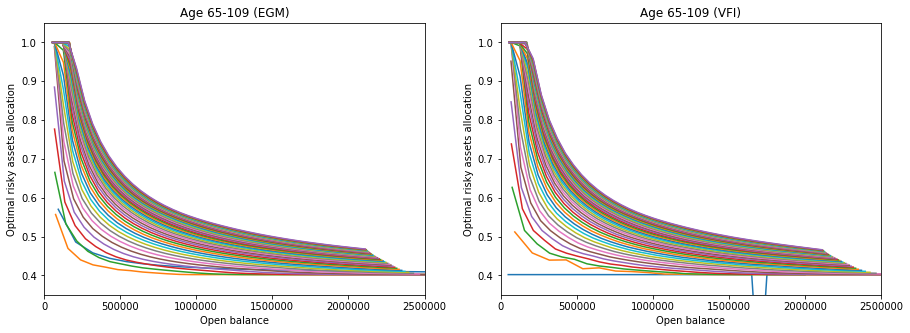

In [21]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for i in range(0,45):
    plt.plot(Optimal_results_EGM.column(4*i+3), Optimal_θx.column(i))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.xlim((0,2500000))
plt.ylim((0.35,1.05))
plt.title('Age 65-109 (EGM)')

plt.subplot(1,2,2)
for i in range(0,45):
    plt.plot(Optimal_results_VFI.column(5*i+0), Optimal_θx_VFI.column(i))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.xlim((0,2500000))
plt.ylim((0.35,1.05))
plt.title('Age 65-109 (VFI)')
# 
# plt.savefig('Portfolio choice, 65-109.png')

Text(0.5,1,'Age 25-64 (VFI)')

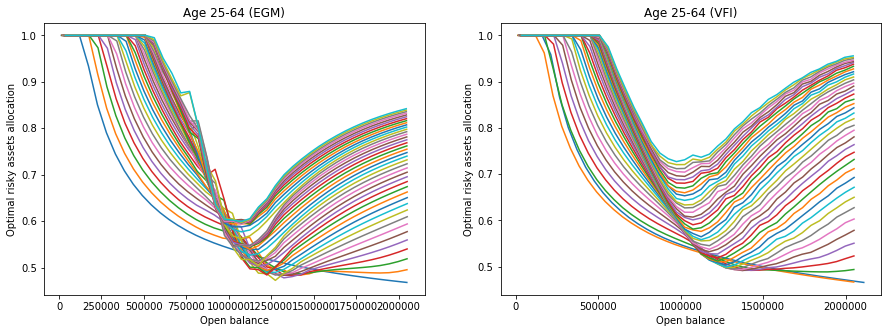

In [22]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
for i in range(40):
    plt.plot(Optimal_results_EGM_25_63.column(6*i+3), Optimal_θx_25_63.column(i)) #, label='age%1d_'%(108-i)
#     plt.pause(0.01)
#     time.sleep(1)
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.title('Age 25-64 (EGM)')

plt.subplot(1,2,2)
for i in range(40):
    plt.plot(Optimal_results_VFI_2.column(5*i+0), Optimal_θx_VFI_25_63.column(i)) #, label='age%1d_'%(108-i)
#     plt.pause(0.01)
#     time.sleep(1)
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation')
plt.title('Age 25-64 (VFI)')

# plt.savefig('Portfolio choice, 25-64.png')

Text(0,0.5,'Optimal consumption')

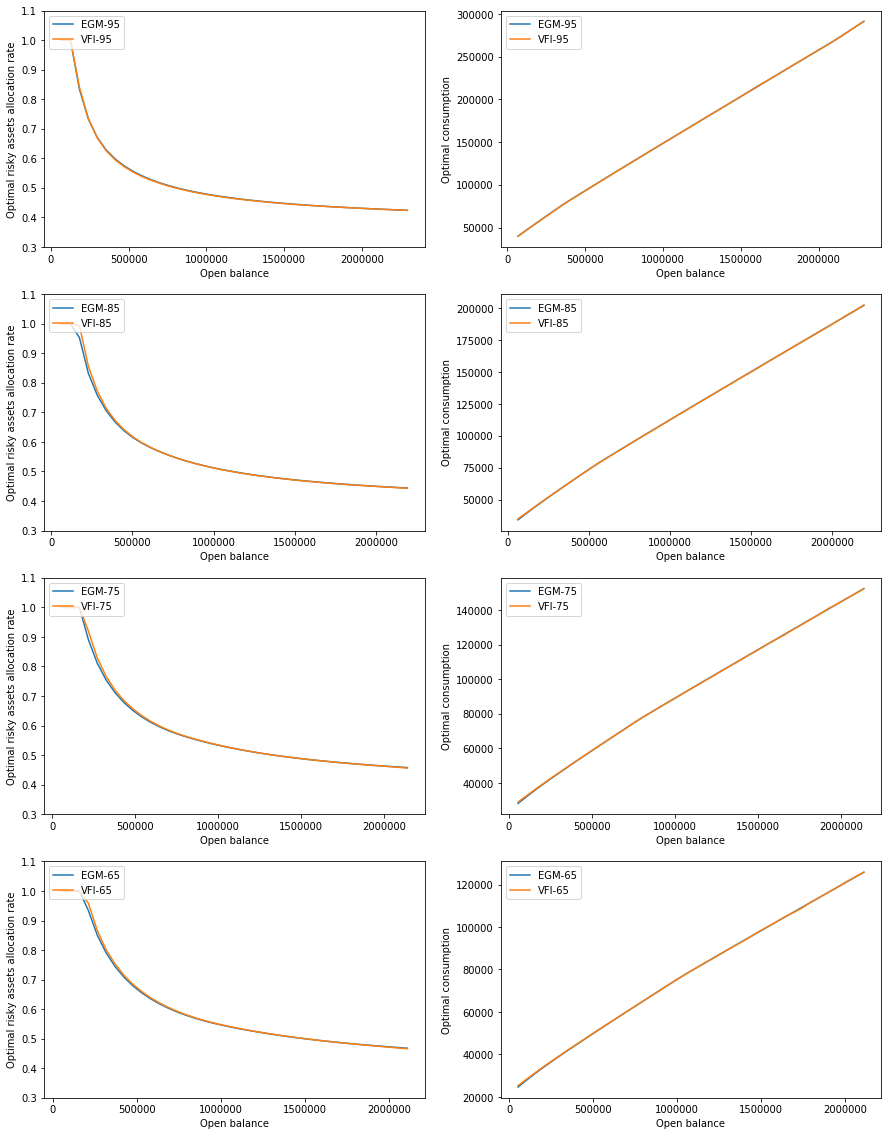

In [23]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM['M95'], Optimal_θx['θ95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_θx_VFI['θ95'])
plt.legend(['EGM-95','VFI-95'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation rate')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM['M95'], Optimal_results_EGM['C95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_results_VFI['C95'])
plt.legend(['EGM-95','VFI-95'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM['M85'], Optimal_θx['θ85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_θx_VFI['θ85'])
plt.legend(['EGM-85','VFI-85'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation rate')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM['M85'], Optimal_results_EGM['C85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_results_VFI['C85'])
plt.legend(['EGM-85','VFI-85'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM['M75'], Optimal_θx['θ75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_θx_VFI['θ75'])
plt.legend(['EGM-75','VFI-75'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation rate')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM['M75'], Optimal_results_EGM['C75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_results_VFI['C75'])
plt.legend(['EGM-75','VFI-75'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM['M65'], Optimal_θx['θ65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_θx_VFI['θ65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal risky assets allocation rate')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['C65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['C65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('C&L&P, 65-95.png')

Text(0,0.5,'Optimal consumption')

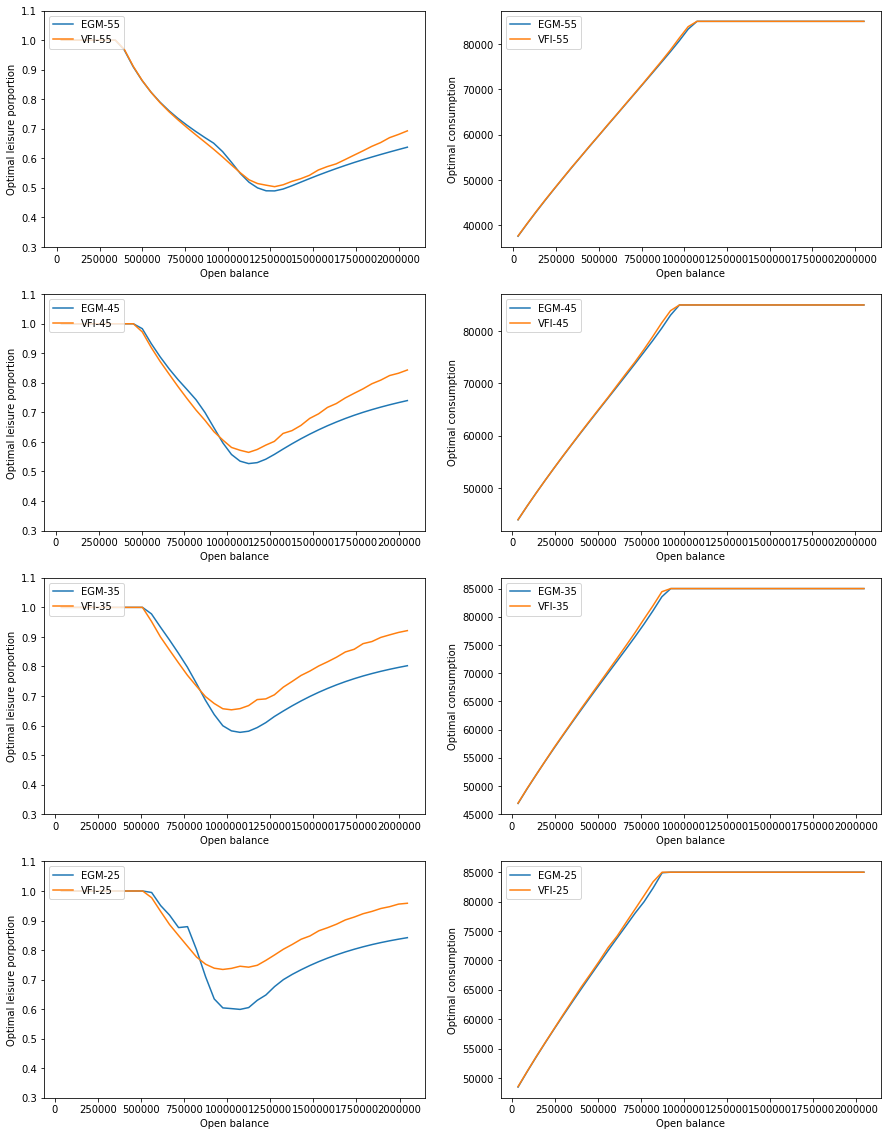

In [24]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_θx_25_63['θ55'])
plt.plot(Optimal_results_VFI_2['M55'], Optimal_θx_VFI_25_63['θ55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
plt.plot(Optimal_results_VFI_2['M55'], Optimal_results_VFI_2['C55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_θx_25_63['θ45'])
plt.plot(Optimal_results_VFI_2['M45'], Optimal_θx_VFI_25_63['θ45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['C45'])
plt.plot(Optimal_results_VFI_2['M45'], Optimal_results_VFI_2['C45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_θx_25_63['θ35'])
plt.plot(Optimal_results_VFI_2['M35'], Optimal_θx_VFI_25_63['θ35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['C35'])
plt.plot(Optimal_results_VFI_2['M35'], Optimal_results_VFI_2['C35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_θx_25_63['θ25'])
plt.plot(Optimal_results_VFI_2['M25'], Optimal_θx_VFI_25_63['θ25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.ylim((0.3,1.1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['C25'])
plt.plot(Optimal_results_VFI_2['M25'], Optimal_results_VFI_2['C25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('C&L&P, 25-65.png')

Text(0,0.5,'Optimal consumption')

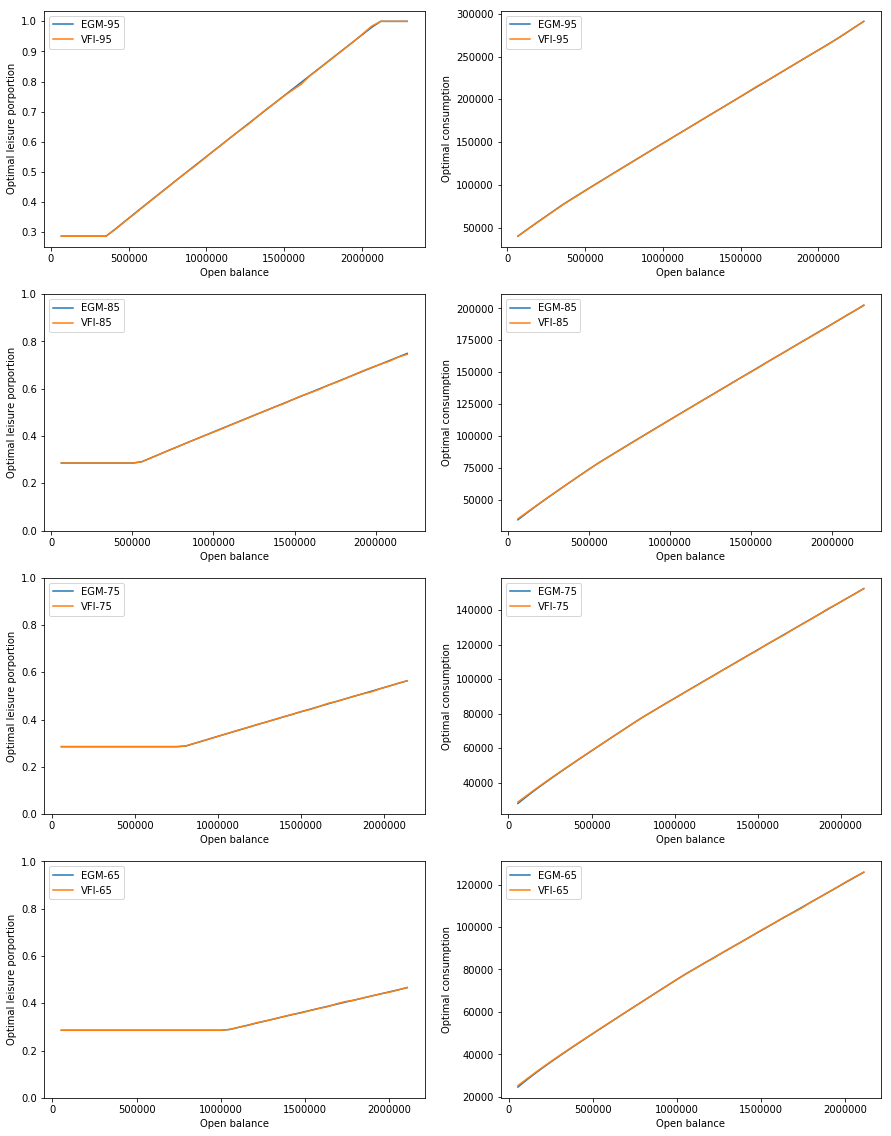

In [25]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM['M95'], Optimal_results_EGM['L95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_results_VFI['L95'])
plt.legend(['EGM-95','VFI-95'], loc='upper left')
# plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM['M95'], Optimal_results_EGM['C95'])
plt.plot(Optimal_results_VFI['M95'], Optimal_results_VFI['C95'])
plt.legend(['EGM-95','VFI-95'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM['M85'], Optimal_results_EGM['L85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_results_VFI['L85'])
plt.legend(['EGM-85','VFI-85'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM['M85'], Optimal_results_EGM['C85'])
plt.plot(Optimal_results_VFI['M85'], Optimal_results_VFI['C85'])
plt.legend(['EGM-85','VFI-85'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM['M75'], Optimal_results_EGM['L75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_results_VFI['L75'])
plt.legend(['EGM-75','VFI-75'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM['M75'], Optimal_results_EGM['C75'])
plt.plot(Optimal_results_VFI['M75'], Optimal_results_VFI['C75'])
plt.legend(['EGM-75','VFI-75'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['L65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['L65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM['M65'], Optimal_results_EGM['C65'])
plt.plot(Optimal_results_VFI['M65'], Optimal_results_VFI['C65'])
plt.legend(['EGM-65','VFI-65'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('EGMvsVFI, α=.9, 65-95.png')

Text(0,0.5,'Optimal consumption')

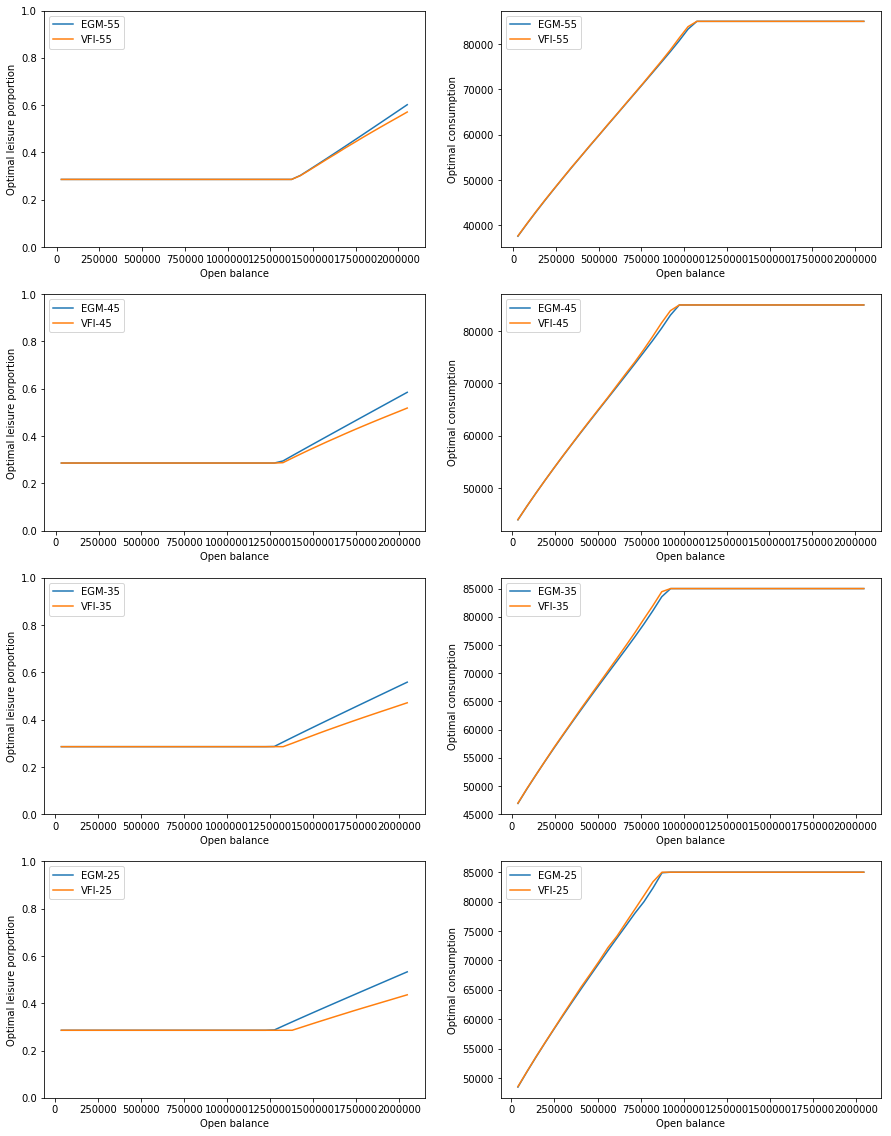

In [26]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['L55'])
plt.plot(Optimal_results_VFI_2['M55'], Optimal_results_VFI_2['L55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,2)
plt.plot(Optimal_results_EGM_25_63['M55'], Optimal_results_EGM_25_63['C55'])
plt.plot(Optimal_results_VFI_2['M55'], Optimal_results_VFI_2['C55'])
plt.legend(['EGM-55','VFI-55'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,3)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['L45'])
plt.plot(Optimal_results_VFI_2['M45'], Optimal_results_VFI_2['L45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,4)
plt.plot(Optimal_results_EGM_25_63['M45'], Optimal_results_EGM_25_63['C45'])
plt.plot(Optimal_results_VFI_2['M45'], Optimal_results_VFI_2['C45'])
plt.legend(['EGM-45','VFI-45'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,5)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['L35'])
plt.plot(Optimal_results_VFI_2['M35'], Optimal_results_VFI_2['L35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,6)
plt.plot(Optimal_results_EGM_25_63['M35'], Optimal_results_EGM_25_63['C35'])
plt.plot(Optimal_results_VFI_2['M35'], Optimal_results_VFI_2['C35'])
plt.legend(['EGM-35','VFI-35'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

plt.subplot(4,2,7)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['L25'])
plt.plot(Optimal_results_VFI_2['M25'], Optimal_results_VFI_2['L25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.ylim((0,1))
plt.xlabel('Open balance')
plt.ylabel('Optimal leisure porportion')

plt.subplot(4,2,8)
plt.plot(Optimal_results_EGM_25_63['M25'], Optimal_results_EGM_25_63['C25'])
plt.plot(Optimal_results_VFI_2['M25'], Optimal_results_VFI_2['C25'])
plt.legend(['EGM-25','VFI-25'], loc='upper left')
plt.xlabel('Open balance')
plt.ylabel('Optimal consumption')

# plt.savefig('figure 2.3.png')

finds out:
1. The risky assets allocation doesn't affect optimal consumption and leisure too much
2. EGM for solving raa at age 65-109 when there is no leisure is problematic
3. 

In [27]:
# Optimal_results_VFI_2.to_csv('C&L&θ,VFI,25-65.csv')